# Programming Assignment 4: Sequence-to-sequence Generation with Transformer

## Overview

<font size='4'>In this assignment you will practice implementing a Transformer-based sequence-to-sequence (seq2seq) generation model using both Transformer encoder and decoder for machine translation (from French to English). On the one hand, you need to implement a custom Transformer decoder. On the other hand, you will also learn how to use PyTorch's built-in multi-head attention and Transformer encoder modules. In this way, you not only deepen your understanding of Transformer by implementing it on your own but also learn how to construct a model for a downstream application using PyTorch's built-in modules. After finishing this programming assignment, you will get good understandings about foundations for very state-of-the-art models that you likely see in tech news articles nowadays, like ChatGPT.</font>

## Submission format

- <font size='4'>`<your_nu_username>_pa4.ipynb` with your implementations and output.</font>

## Note

<font size='4'>  

- **Read the instructions and comments very carefully to avoid waste of your valuable time and deductions of points.**

- You do not install any additional packages inside the Colab environment. Do not forget to choose to use GPU in the `Runtime\Change runtime type` tab.    

- **You are not allowed to look for answers online, except for the links provided in this assignment.**

- **Violation of this policy will lead to failure of your course and even more severe consequences.**

- Attend office hours and make posts on Piazza if you have any questions.
</font>


## Setup

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import math
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# We will be using the official implementation of the multi-head attention
from torch.nn import MultiheadAttention, TransformerEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using the device {}.'.format(device))

We are using the device cuda.


## Data Preparation

<font size='4'> The data preparation part is largely borrowed (with modifications) from an online tutorial https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html. You are encouraged to read it and allowed to take inspirations from their implementations of the RNN-based seq2seq model.

In [2]:
# Download the data
!wget https://download.pytorch.org/tutorial/data.zip
!unzip -o data.zip

--2025-04-07 12:17:14--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 3.167.212.82, 3.167.212.110, 3.167.212.24, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.167.212.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.06s   

2025-04-07 12:17:14 (42.4 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Itali

In [3]:
"""
We'll need a unique index per word to use as the inputs and targets of the networks later.
To keep track of all this we will use a helper class called Lang which has
word → index (word2index) and index → word (index2word) dictionaries, as well as a count
of each word word2count which will be used to replace rare words later.
"""

# Define two special tokens here
# SOS - start of a sentence
# EOS - end of a sentence
SOS_token = 0
EOS_token = 1

# Note that the PAD token is not defined here, which may affect the performance, but not critically.

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        # SOS - start of sentence
        # EOS - end of sentence
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
"""
The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.
"""

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [5]:
"""
To read the data file we will split the file into lines, and then split lines into pairs.
The files are all English → Other Language, so if we want to translate from
Other Language → English I added the reverse flag to reverse the pairs.
"""

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
"""
Since there are a lot of example sentences and we want to train something quickly,
we'll trim the data set to only relatively short and simple sentences.
Here the maximum length is 10 words (that includes ending punctuation) and
we're filtering to sentences that translate to the form "I am" or "He is" etc.
(accounting for apostrophes replaced earlier).
"""

MAX_LENGTH = 10

ENG_PREFIXES = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p, max_length, eng_prefixes=None):
    condition = len(p[0].split(' ')) < max_length and \
        len(p[1].split(' ')) < max_length
    if eng_prefixes is not None:
        condition = condition and p[1].startswith(eng_prefixes)
    return condition

def filterPairs(pairs, max_length, eng_prefixes=None):
    return [pair for pair in pairs if filterPair(pair, max_length, eng_prefixes)]

In [7]:
"""
The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs
"""

def prepareData(lang1, lang2, max_length, eng_prefixes=ENG_PREFIXES, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, max_length, eng_prefixes)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

# Let's see what the data looks like
input_lang, output_lang, pairs = prepareData('eng', 'fra', MAX_LENGTH, ENG_PREFIXES, True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['tu n es pas autorisee a manger ceux la', 'you re not allowed to eat those']


In [8]:
"""
To train, for each pair we will need an input tensor (indexes of the words in
the input sentence) and target tensor (indexes of the words in the target sentence).
While creating these vectors we will append the EOS token to both sequences.
"""

from torch.utils.data import TensorDataset, DataLoader, RandomSampler

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def convert_pairs_to_dataloader(pairs, batch_size, is_train):
    n = len(pairs)
    input_ids = np.ones((n, MAX_LENGTH), dtype=np.int32) * EOS_token
    target_ids = np.ones((n, MAX_LENGTH + 1), dtype=np.int32) * EOS_token

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    data = TensorDataset(torch.LongTensor(input_ids).to(device),
                         torch.LongTensor(target_ids).to(device))

    if is_train:
        sampler = RandomSampler(data)
        dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size, drop_last=True)#, num_workers=2)
    else:
        dataloader = DataLoader(data, sampler=None, batch_size=batch_size, drop_last=False)#, num_workers=2)
    return dataloader

def get_dataloader(pairs, batch_size):
    np.random.shuffle(pairs)

    n = len(pairs)
    n_train = int(n * 0.9)
    train_pairs = pairs[:n_train]
    test_pairs = pairs[n_train:]
    train_dataloader = convert_pairs_to_dataloader(train_pairs, batch_size, True)
    test_dataloader = convert_pairs_to_dataloader(test_pairs, batch_size, False)

    return train_pairs, train_dataloader, test_pairs, test_dataloader

## Auxiliary Modules and Functions

<font size='4'>You have implemented some of them in the third programming assignment, which are needed for this assignment, too. So their reference implementations are provided here.

In [9]:
class FeedForwardNetwork(nn.Module):
    """
    A simple feedforward network. Essentially, it is a two-layer fully-connected
    neural network.
    """
    def __init__(self, input_dim, ff_dim, dropout):
        """
        Inputs:
        - input_dim: Input dimension
        - ff_dim: Hidden dimension
        """
        super(FeedForwardNetwork, self).__init__()

        ###########################################################################
        # TODO: Define the two linear layers and a non-linear one.
        ###########################################################################
        self.w1 = nn.Linear(input_dim, ff_dim)
        self.w2 = nn.Linear(ff_dim, input_dim)
        self.non_linear = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x: torch.Tensor):
        """
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
         and C is the channel dimension

        Return:
        - y: Tensor of the shape BxLxC
        """

        y = None
        ###########################################################################
        # TODO: Process the input.                                                #
        ###########################################################################
        y = self.dropout(self.non_linear(self.w1(x)))
        y = self.w2(y)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return y


In [10]:
class PositionalEncoding(nn.Module):
    """
    A module that adds positional encoding to each of the token's features.
    So that the Transformer is position aware.
    """
    def __init__(self, input_dim: int, max_len: int=10000):
        """
        Inputs:
        - input_dim: Input dimension about the features for each token
        - max_len: The maximum sequence length
        """
        super(PositionalEncoding, self).__init__()

        self.input_dim = input_dim

    def forward(self, x):
        """
        Compute the positional encoding and add it to x.

        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension

        Return:
        - x: Tensor of the shape BxLxC, with the positional encoding added to the input
        """
        seq_len = x.shape[1]
        input_dim = x.shape[2]

        pe = None
        ###########################################################################
        # TODO: Compute the positional encoding                                   #
        # Check Section 3.5 for the definition (https://arxiv.org/pdf/1706.03762.pdf)
        #                                                                         #
        # It's a bit messy, but the definition is provided for your here for your #
        # convenience (in LaTex).                                                 #
        # PE_{(pos,2i)} = sin(pos / 10000^{2i/\dmodel}) \\                        #
        # PE_{(pos,2i+1)} = cos(pos / 10000^{2i/\dmodel})                         #
        #                                                                         #
        # You should replace 10000 with max_len here.
        ###########################################################################
        norm = 10000.0 ** (torch.arange(0, self.input_dim, 2) / input_dim)
        pos = torch.arange(seq_len).unsqueeze(1)
        pe = torch.zeros(seq_len, input_dim)
        pe[:, ::2]  = torch.sin(pos / norm)
        pe[:, 1::2] = torch.cos(pos / norm)
        pe = pe.unsqueeze(0)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        x = x + pe.to(x.device)
        return x

torch.Size([20, 20])


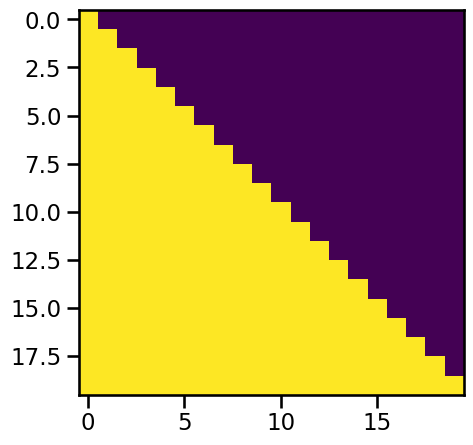

In [11]:
# Create and visualize the causal mask that is needed for training of the decoder
# in a Transformer-based seq2seq model.

def create_causal_mask(size):
    "Mask out subsequent positions. Also known as a causual mask."
    attn_shape = (size, size)
    causal_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(causal_mask) == 0

# Let's visualize what the target mask looks like
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")

causal_mask = create_causal_mask(20)
print(causal_mask.shape)

plt.figure(figsize=(5,5))
plt.imshow(causal_mask.numpy())


<font size='4' color='red'> Your implementations start from here.</font>

## Part 1: Implementation of the Transformer decoder and seq2seq model (60 points)

### <font size='4' color='red'>Task 1.1: Implement Transformer Decoder Cell (15 points)</font>

In [12]:
class MyTransformerDecoderCell(nn.Module):
    """
    A single cell (unit) of the Transformer decoder.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout: float=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(MyTransformerDecoderCell, self).__init__()

        ###########################################################################
        # TODO: Define two multi-head attention modules using                     #
        # nn.MultiheadAttention. See the API definition at                        #
        # https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html#
        # Note that you need to set batch_first=True. Out of the two multi-head   #
        # attention modules, one is for processing the tokens on the decoder side,#
        # dong self attention. The other is doing cross attention, getting the    #
        # attention from the decoder embeddings to the encoder embeddings. Also   #
        # define a feedforward network. Don't forget the Dropout and LayerNorm    #
        # layers.                                                                 #
        #                                                                         #
        # Note that you need to implement the post-norm variant here.             #
        ###########################################################################
        self.self_attn = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads,
                                               dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads,
                                                dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(input_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, input_dim)

        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.norm3 = nn.LayerNorm(input_dim)

        self.dropout = nn.Dropout(dropout)
        self.dropout_ff = nn.Dropout(dropout)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###############################a############################################

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, tgt_mask=None, tgt_is_causal=False):
        """
        Inputs:
        - x: Tensor of BxLdxC, word embeddings on the decoder side
        - encoder_output: Tensor of BxLexC, word embeddings on the encoder side
        - tgt_mask: Tensor, causal mask for the self attention of the tokens on the
          decoder side, which prevents each token to attend to future tokens
        - tgt_is_causal: Boolean, indicating whether the tgt_mask is causal or not.
          If a causal mask is provided, make sure setting tgt_is_causal=True when calling
          the self attention module. These arguments are defined in accordance with the
          interface of nn.TransformerDecoderCell so you can use it for debugging purpose.

        Return:
        - y: Tensor of BxLdxC. Attended features for all tokens on the decoder side.
        """

        y = None
        ###########################################################################
        # TODO: Compute the self-attended features for the tokens on the decoder  #
        # side. Then compute the cross-attended features for the tokens on the    #
        # decoder side to the encoded features, which are finally fed into the    #
        # feedforward network.                                                    #
        ###########################################################################
        residual = x
        x_sa, _ = self.self_attn(x, x, x, attn_mask=tgt_mask, is_causal=tgt_is_causal)
        x = self.norm1(residual + self.dropout(x_sa))

        residual = x
        x_ca, _ = self.cross_attn(x, encoder_output, encoder_output)
        x = self.norm2(residual + self.dropout(x_ca))

        residual = x
        x_ff = self.linear2(F.relu(self.linear1(x)))
        y = self.norm3(residual + self.dropout_ff(x_ff))
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return y


In [13]:
# Sanity check with a decoder causal mask
dec_embed = torch.randn((3, 10, 16))
dec_causal_mask = create_causal_mask(10) # why 10 here?

enc_embed = torch.randn((3, 12, 16))

model = MyTransformerDecoderCell(16, 2, 32, 0.1)
z = model(dec_embed, enc_embed, dec_causal_mask, tgt_is_causal=True)
assert len(z.shape) == len(dec_embed.shape)
for dim_z, dim_x in zip(z.shape, dec_embed.shape):
    assert dim_z == dim_x
print('output shape: ', z.shape)

output shape:  torch.Size([3, 10, 16])


### <font size='4' color='red'>Task 1.2: Implement Transformer Decoder (12 points)</font>

In [14]:
class MyTransformerDecoder(nn.Module):
    """
    A MyTransformerDecoder is a stack of multiple MyTransformerDecoderCells and a Layer Norm.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: How many MyTransformerDecoderCells in stack
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(MyTransformerDecoder, self).__init__()

        ###########################################################################
        # TODO: Construct a nn.ModuleList to store a stack of                     #
        # MyTranformerDecoderCells. Check the documentation here of how to use it #
        # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList
        #                                                                         #
        # At the same time, define a layer normalization layer to process the     #
        # output of the entire decoder.                                           #
        #                                                                         #
        # For debugging purpose, you can replace MyTranformerDecoderCell with the #
        # built-in nn.TranformerDecoderCell.                                      #
        ###########################################################################
        self.layers = nn.ModuleList([
            MyTransformerDecoderCell(input_dim=input_dim,
                                      num_heads=num_heads,
                                      ff_dim=ff_dim,
                                      dropout=dropout)
            for _ in range(num_cells)
        ])

        self.norm = nn.LayerNorm(input_dim)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, dec_causal_mask=None):
        """
        Inputs:
        - x: Tensor of BxLdxC, word embeddings on the decoder side
        - encoder_output: Tensor of BxLexC, word embeddings on the encoder side
        - dec_causal_mask: Tensor, causal mask for the self attention of the tokens on the
          decoder side, which prevents each token to attend to future tokens

        Return:
        - y: Tensor of BxLdxC. Attended features for all tokens on the decoder side.
        """

        y = None
        ###########################################################################
        # TODO: Feed x into the stack of MyTransformerDecoderCells and then       #
        # normalize the final output with layer norm.                             #
        #                                                                         #
        # Note: when calling TransformerDecoderCell, if a dec_causal_mask is      #
        # provided, make sure to set tgt_is_causal=True.                          #
        ###########################################################################
        for layer in self.layers:
          x = layer(x, encoder_output, tgt_mask=dec_causal_mask, tgt_is_causal=(dec_causal_mask is not None))


        y = self.norm(x)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return y


In [15]:
# Sanity check of tensor shapes
dec_embed = torch.randn((3, 10, 16))
dec_causal_mask = create_causal_mask(10)

enc_embed = torch.randn((3, 12, 16))

model = MyTransformerDecoder(16, 2, 32, 2, 0.1)
z = model(dec_embed, enc_embed, dec_causal_mask)
assert len(z.shape) == len(dec_embed.shape)
for dim_z, dim_x in zip(z.shape, dec_embed.shape):
    assert dim_z == dim_x
print('output shape: ', z.shape)

output shape:  torch.Size([3, 10, 16])


<font size='4' color='red'>Task 1.3 (inline question): As you can see below, for a Transformer-based seq2seq model, due to the existence of the Transformer decoder, you need to implement `forward_train` and `forward_test`, corresponding its different behaviors in training and testing time. Briefly explain why you need to do so. (8 points) </font>

During training, we have access to the ground truth target sequence, so we can use teacher forcing, where the decoder receives the actual previous token as input at each time step. This allows the model to learn more effectively by directly comparing predictions to the correct sequence.

However, during testing, we don’t have the ground truth targets, so we need to generate tokens one at a time, feeding the decoder's own previous prediction as the next input. This step-by-step generation is necessary to simulate how the model would actually perform in a real-world setting.

Because of this difference in input behavior, we need two separate methods: forward_train for batch training with teacher forcing, and forward_test for autoregressive inference during testing.

### <font size='4' color='red'>Task 1.4: Implement a Transformer-based sequence-to-sequence model (25 points: 5 for the constructor, 10 for forward_train, and 10 for forward_test)</font>

In [16]:
class Seq2SeqTransformer(nn.Module):
    """
    Transformer-based sequence-to-sequence model.
    """
    def __init__(self,
            num_encoder_layers: int, num_decoder_layers: int, embed_dim: int,
            num_heads: int, src_vocab_size: int, tgt_vocab_size: int,
            trx_ff_dim: int = 512, dropout: float = 0.1
        ):
        """
        Inputs:
        - num_encoder_layers: How many TransformerEncoderCell in stack
        - num_decoder_layers: How many TransformerDecoderCell in stack
        - embed_dim: Word embeddings dimension
        - num_heads: Number of attention heads
        - src_vocab_size: Number of tokens in the source language vocabulary
        - tgt_vocab_size: Number of tokens in the target language vocabulary
        - trx_ff_dim: Hidden dimension in the feedforward network
        - dropout: Dropout ratio
        """
        super(Seq2SeqTransformer, self).__init__()

        self.embed_dim = embed_dim

        # Word embeddings for both the source and target languages
        self.src_token_embed = nn.Embedding(src_vocab_size, embed_dim)
        self.tgt_token_embed = nn.Embedding(tgt_vocab_size, embed_dim)

        self.encoder = None
        self.decoder = None
        self.output_layer = None
        ###########################################################################
        # TODO: Define the positional encoding module, encoder, decoder, and the  #
        # output layer. Think of how many classes are in the output layer.        #
        #                                                                         #
        # For the encoder, you'll use nn.TransformerEncoderLayer and              #
        # nn.TransformerEncoder.  Check                                           #
        # https://pytorch.org/docs/stable/nn.html#transformer-layers for how to   #
        # use them.                                                               #
        #                                                                         #
        # For the decoder, you'll use your own MyTransformerDecoder. But for      #
        # the debugging purpose, you can use nn.TransformerDecoderLayer and       #
        # nn.TransformerDecoder.                                                  #
        ###########################################################################
        self.pos_encoder = nn.Parameter(torch.zeros(1, 1000, embed_dim))  # Fixed max length
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                       dim_feedforward=trx_ff_dim, dropout=dropout,
                                       batch_first=True),
            num_layers=num_encoder_layers
        )

        self.decoder = MyTransformerDecoder(
            input_dim=embed_dim,
            num_heads=num_heads,
            ff_dim=trx_ff_dim,
            num_cells=num_decoder_layers,
            dropout=dropout
        )

        self.output_layer = nn.Linear(embed_dim, tgt_vocab_size)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward_train(self, src: torch.Tensor, tgt: torch.Tensor, use_causal_mask=True):
        """
        Inputs:
        - src: Tensor of BxLe, word indexes in the source language
        - tgt: Tensor of BxLd, word indexes in the target language
        - use_causal_mask: Boolean, indicating whether to use a causal mask in the
          decoder. We will use it to examine different behaviors of the model.

        Return:
        - y: Tensor of BxLdxK, corresponding to the log probabilities of generated
             words in the target language. K is the number of classes in the output.
        """
        # Get source language word embeddings. Note they are scaled.
        src_embed = self.src_token_embed(src) * math.sqrt(self.embed_dim)

        # Append an initial SOS token
        init_token = torch.empty(src_embed.shape[0], 1, dtype=torch.long, device=tgt.device).fill_(SOS_token)
        tgt_sentence = torch.cat((init_token, tgt), dim=1)
        # Get target language word embeddings. Note they are scaled.
        tgt_embed = self.tgt_token_embed(tgt_sentence) * math.sqrt(self.embed_dim)

        logits = None
        ###########################################################################
        # TODO: Add positional encodings to the word embeddings of the source and #
        # target languages. Then feed them to the encoder and decoder,            #
        # respectively and get the logits finally.                                #
        #                                                                         #
        # Note that no for loop is allowed here.                                  #
        ###########################################################################
        src_embed = src_embed + self.pos_encoder[:, :src_embed.size(1), :]
        tgt_embed = tgt_embed + self.pos_encoder[:, :tgt_embed.size(1), :]

        memory = self.encoder(src_embed)
        decoder_output = self.decoder(tgt_embed, memory, dec_causal_mask=None if not use_causal_mask else
                                      nn.Transformer.generate_square_subsequent_mask(tgt_embed.size(1)).to(tgt.device))

        logits = self.output_layer(decoder_output)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        # We discard the last token's output (the output of the EOS token), which is meaningless.
        logits = logits[:, :-1]

        # We compute the log probabilities as we will use nn.NLLLoss() as the loss function
        return F.log_softmax(logits, dim=-1)

    def forward_test(self, src):
        """
        Inputs:
        - src: Tensor of BxLe, word indexes in the source language

        Return:
        - y: Tensor of BxLdxK, corresponding to the log probabilities of generated
             words in the target language. K is the number of classes in the output.
        """
        # Get source language word embeddings. Note they are scaled.
        src_embed = self.src_token_embed(src) * math.sqrt(self.embed_dim)

        # For the target language generation, we always start from a SOS token.
        decoder_input = torch.empty(src.shape[0], 1, dtype=torch.long, device=device).fill_(SOS_token)

        logits = []
        ###########################################################################
        # TODO: Add positional encodings to the word embeddings of the source     #
        # language, from which we will generate one word at a time based on the   #
        # previously generated ones (so called autoregressive generation) in the  #
        # target language. We will generate MAX_LENGTH + 1 (a global variable     #
        # defined earlier) words, **including the EOS token**, at the most using a#
        # for loop. You may find the implementation of DecoderRNN in the tutorial #
        # https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
        # helpful. But be aware of the differences of RNN and Transformer in      #
        # terms of autoregressive generation.                                     #
        ###########################################################################
        src_embed = src_embed + self.pos_encoder[:, :src_embed.size(1), :]
        memory = self.encoder(src_embed)

        for _ in range(MAX_LENGTH + 1):
            tgt_embed = self.tgt_token_embed(decoder_input) * math.sqrt(self.embed_dim)
            tgt_embed = tgt_embed + self.pos_encoder[:, :tgt_embed.size(1), :]

            decoder_output = self.decoder(tgt_embed, memory, dec_causal_mask=None)
            out = self.output_layer(decoder_output[:, -1:, :])  # last token only
            logits.append(out)

            next_token = out.argmax(-1)
            decoder_input = torch.cat((decoder_input, next_token), dim=1)

            if (next_token == EOS_token).all():
                break

        logits = torch.cat(logits, dim=1)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        # Keep the returned tensor the same as the training time
        return F.log_softmax(logits, dim=-1)

    def forward(self, src, tgt=None, use_causal_mask=True):
        """
        Inputs:
        - src: Tensor of BxLe, word indexes in the source language
        - tgt: Tensor of BxLd, word indexes in the target language. Can be empty.
        - use_causal_mask: Boolean, indicating whether to use a causal mask in the
          decoder. We will use it to examine different behaviors of the model.

        Return:
        - y: Tensor of BxLdxK, corresponding to the log probabilities of generated
             words in the target language. K is the number of classes in the output.
        """
        if self.training:
            # Training-time behavior
            assert tgt is not None
            return self.forward_train(src, tgt, use_causal_mask)

        # Testing-time behavior
        return self.forward_test(src)


In [17]:
# Sanity check of tensor shapes
src_vocab_size = 10
src = torch.arange(src_vocab_size).view(1, -1)
src = torch.cat((src, src), dim=0)

tgt_vocab_size = 12
tgt = torch.arange(tgt_vocab_size - 3).view(1, -1)
tgt = torch.cat((tgt, tgt), dim=0)

print('src: ', src.shape)
print('tgt: ', tgt.shape)

model = Seq2SeqTransformer(2, 2, 16, 2, src_vocab_size, tgt_vocab_size, 32, 0.1)
z = model(src, tgt)
desired_output_shape = [2, 9, 12]
assert len(z.shape) == len(desired_output_shape)
for dim_z, dim_x in zip(z.shape, desired_output_shape):
    assert dim_z == dim_x
print('output shape: ', z.shape)

src:  torch.Size([2, 10])
tgt:  torch.Size([2, 9])
output shape:  torch.Size([2, 9, 12])


## Part 2: Train Transformer-based seq2seq models (40 points).

In [18]:
"""
This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.
"""

import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [19]:
"""
The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting
Then we call train many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.
"""
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [20]:
"""
To train we run the input sentence through the encoder, and keep track of every
output and the latest hidden state. Then the decoder is given the <SOS> token as
 its first input, and the last hidden state of the encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as each next
input, instead of using the decoder's guess as the next input. Using teacher
forcing causes it to converge faster but when the trained network is exploited,
it may exhibit instability.

You can observe outputs of teacher-forced networks that read with coherent grammar
but wander far from the correct translation -intuitively it has learned to represent
the output grammar and can "pick up" the meaning once the teacher tells it the
first few words, but it has not properly learned how to create the sentence from
the translation in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly choose to use
teacher forcing or not with a simple if statement. Turn teacher_forcing_ratio
up to use more of it.
"""

def train_epoch(dataloader, model, optimizer, criterion, lr_scheduler, use_causal_mask):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        optimizer.zero_grad()

        decoder_outputs = model(input_tensor, target_tensor, use_causal_mask)

        # The neg-log likelihood loss of language generation is also known as perplexity.
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        optimizer.step()

        lr_scheduler.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def train(train_dataloader, model, n_epochs, optimizer, lr_scheduler, use_causal_mask, learning_rate=0.001, print_every=100, plot_every=100):
    model.train()
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, model, optimizer, criterion, lr_scheduler, use_causal_mask)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) loss: %.4f, lr: %.6f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg, lr_scheduler.get_last_lr()[0]))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [21]:
def evaluate(model, sentence, input_lang, output_lang):
    model.eval()
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        decoder_outputs = model(input_tensor)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words

def evaluateRandomly(model, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(model, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

<font size='4' color='red'>Task 2.1: Sanity check of fitting a small training set. (5 points) </font>

Reading lines...
Read 135842 sentence pairs
Trimmed to 9207 sentence pairs
Counting words...
Counted words:
fra 3934
eng 2542
Number of parameters for the entire model:	0.425M
Number of parameters for the encoder:	0.042M
Number of parameters for the decoder:	0.060M
0m 5s (- 0m 46s) (5 10%) loss: 3.9985, lr: 0.001000
0m 9s (- 0m 38s) (10 20%) loss: 2.0806, lr: 0.001000
0m 13s (- 0m 31s) (15 30%) loss: 1.6230, lr: 0.001000
0m 17s (- 0m 26s) (20 40%) loss: 1.3404, lr: 0.001000
0m 21s (- 0m 21s) (25 50%) loss: 1.1169, lr: 0.001000
0m 24s (- 0m 16s) (30 60%) loss: 0.9177, lr: 0.001000
0m 29s (- 0m 12s) (35 70%) loss: 0.7456, lr: 0.001000
0m 32s (- 0m 8s) (40 80%) loss: 0.6034, lr: 0.001000
0m 36s (- 0m 4s) (45 90%) loss: 0.4739, lr: 0.001000
0m 40s (- 0m 0s) (50 100%) loss: 0.3666, lr: 0.001000


<Figure size 640x480 with 0 Axes>

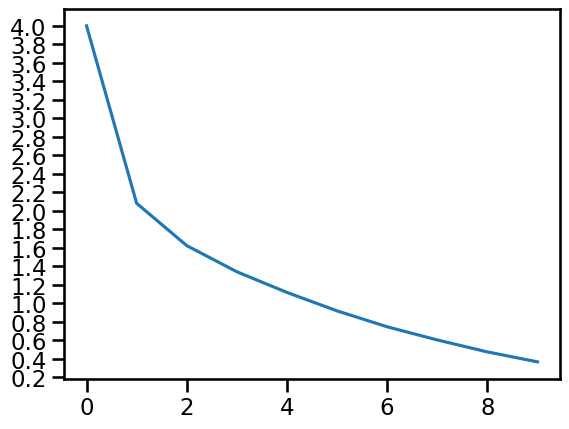

In [22]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

def get_num_params(model):
    return sum(p.numel() for p in model.parameters())

# re-set MAX_LENGTH
MAX_LENGTH = 8
input_lang, output_lang, pairs = prepareData('eng', 'fra', MAX_LENGTH, ENG_PREFIXES, True)
np.random.shuffle(pairs)
# Let's just use 1000 samples
pairs = pairs[:1000]

BATCH_SIZE = 32
EMBED_DIM = 32
NUM_ATTN_HEADS = 4
FF_DIM = 96
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
###########################################################################
# TODO: Define the model to fit to a small training set reasonably well.  #
# Your training loss should be around 0.5.                                #
###########################################################################
model = Seq2SeqTransformer(
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    embed_dim=EMBED_DIM,
    num_heads=NUM_ATTN_HEADS,
    src_vocab_size=input_lang.n_words,
    tgt_vocab_size=output_lang.n_words,
    trx_ff_dim=FF_DIM,
    dropout=0.1
).to(device)
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

# We will clone the model for later usage
import copy
model_clone = copy.deepcopy(model)

print('Number of parameters for the entire model:\t{:.3f}M'.format(get_num_params(model) / 1e6))
print('Number of parameters for the encoder:\t{:.3f}M'.format(get_num_params(model.encoder) / 1e6))
print('Number of parameters for the decoder:\t{:.3f}M'.format(get_num_params(model.decoder) / 1e6))

train_pairs, train_dataloader, _, _ = get_dataloader(pairs, BATCH_SIZE)

optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1)

# Your train loss should be around 0.5.
train(train_dataloader, model, 50, optimizer, lr_scheduler, use_causal_mask=True, print_every=5, plot_every=5)


In [23]:
# Let's check the model's output
print('\n=== Sample output on the training set. ===')
evaluateRandomly(model, train_pairs)


=== Sample output on the training set. ===
> tu as parfaitement raison
= you are absolutely right
< you are absolutely right <EOS>

> je suis sur que vous allez reussir
= i m sure that you ll succeed
< i m sure that you of you <EOS>

> je ne suis pas enseignant
= i m not a teacher
< i m not a little business <EOS>

> je prevois de jouer au football demain
= i am going to play soccer tomorrow
< i am going to play soccer tomorrow <EOS>

> je suis ouvert aux suggestions
= i m open to suggestions
< i m open to suggestions <EOS>

> je suis nul en langues
= i m terrible at languages
< i m terrible at languages <EOS>

> je vais dormir
= i am going to sleep
< i am going to get dressed <EOS>

> nous avons fini
= we re finished
< we re done <EOS>

> on n a pas besoin de nous
= we re not needed
< we re not needed <EOS>

> je ne suis pas vegetarienne
= i m not a vegetarian
< i m not a vegetarian <EOS>



0m 3s (- 0m 33s) (5 10%) loss: 4.0088, lr: 0.001000
0m 7s (- 0m 31s) (10 20%) loss: 2.0154, lr: 0.001000
0m 11s (- 0m 26s) (15 30%) loss: 1.4995, lr: 0.001000
0m 14s (- 0m 22s) (20 40%) loss: 1.1850, lr: 0.001000
0m 19s (- 0m 19s) (25 50%) loss: 0.9440, lr: 0.001000
0m 22s (- 0m 15s) (30 60%) loss: 0.7372, lr: 0.001000
0m 26s (- 0m 11s) (35 70%) loss: 0.5652, lr: 0.001000
0m 30s (- 0m 7s) (40 80%) loss: 0.4230, lr: 0.001000
0m 34s (- 0m 3s) (45 90%) loss: 0.3075, lr: 0.001000
0m 37s (- 0m 0s) (50 100%) loss: 0.2241, lr: 0.001000


<Figure size 640x480 with 0 Axes>

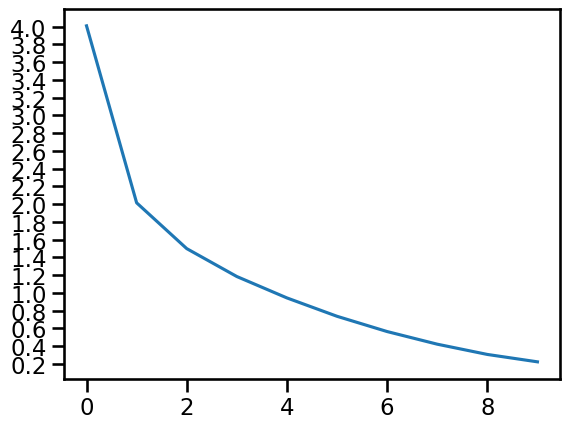


=== Sample output on the training set. ===
> je suis un peu desoriente
= i m a little confused
< you <EOS>

> vous etes des cretins
= you are morons
< you are free as now <EOS>

> je me prepare au pire
= i m getting ready for the worst
< i am leaving now and healthy for curious for

> vous etes si pathetique
= you re so pathetic
< you are you are you are you are you

> vous etes de retour
= you re back
< you to see you to see you to see

> il manque de pratique
= he s out of practice
< you are children <EOS>

> c est nous qui dirigeons
= we re in charge
< you are beautiful than you are beautiful than you

> vous etes tres genereuses
= you re very generous
< you one the one the one the one the

> il est en train de pleurer
= he s crying
< he s crying with with with with with with

> vous etes un sacre coco
= you re a jolly good feller
< you re famous <EOS>



In [24]:
# Let's re-train exactly the same model but without using the causal masks
optimizer = optim.Adam(model_clone.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1)

train(train_dataloader, model_clone, 50, optimizer, lr_scheduler, use_causal_mask=False, print_every=5, plot_every=5)
print('\n=== Sample output on the training set. ===')
evaluateRandomly(model_clone, train_pairs)

<font size='4' color='red'>Task 2.2 (inline question): Briefly summarize and explain your observation of the model's performance when it is trained without using the causal masks. (8 points) </font>

When training the model without causal masks, I observed that the training loss dropped significantly—in my case, it went down to nearly 0.1 or lower, which initially seemed like great performance. However, when I evaluated the model on the training set using evaluateRandomly(model_clone, train_pairs), many of the generated sentences were either incomplete, repetitive, or did not match the target translations well.

This mismatch is because, during training without a causal mask, the decoder can attend to future tokens in the target sequence. This gives the model an unfair advantage, allowing it to use information that it wouldn't have access to during real inference (where generation happens one token at a time). As a result, while it "memorizes" the training data very well (reflected by low loss), it fails to generalize.

This is evident when comparing the performance of the masked vs. unmasked models: the masked model had slightly higher training loss (~0.5), but produced more accurate and consistent translations during evaluation. The unmasked model, despite a low training loss, performed worse in terms of output quality—highlighting the importance of using causal masking to enforce autoregressive behavior and enable better generalization at inference time.

<font size='4' color='red'>Task 2.3: Train a good machine translation model. (20 points) </font>

Reading lines...
Read 135842 sentence pairs
Trimmed to 14636 sentence pairs
Counting words...
Counted words:
fra 6114
eng 3701
Number of parameters for the entire model:	3.351M
Number of parameters for the encoder:	0.502M
Number of parameters for the decoder:	0.754M
0m 8s (- 4m 19s) (1 3%) loss: 2.3326, lr: 0.001000
0m 17s (- 4m 10s) (2 6%) loss: 1.4612, lr: 0.001000
0m 26s (- 3m 56s) (3 10%) loss: 1.0424, lr: 0.001000
0m 35s (- 3m 48s) (4 13%) loss: 0.7393, lr: 0.001000
0m 44s (- 3m 40s) (5 16%) loss: 0.5244, lr: 0.001000
0m 53s (- 3m 32s) (6 20%) loss: 0.3846, lr: 0.001000
1m 1s (- 3m 21s) (7 23%) loss: 0.2932, lr: 0.001000
1m 10s (- 3m 13s) (8 26%) loss: 0.2407, lr: 0.001000
1m 19s (- 3m 5s) (9 30%) loss: 0.2066, lr: 0.001000
1m 28s (- 2m 56s) (10 33%) loss: 0.1890, lr: 0.001000
1m 36s (- 2m 47s) (11 36%) loss: 0.1714, lr: 0.001000
1m 45s (- 2m 38s) (12 40%) loss: 0.1632, lr: 0.001000
1m 54s (- 2m 29s) (13 43%) loss: 0.1529, lr: 0.001000
2m 3s (- 2m 20s) (14 46%) loss: 0.1459, lr: 0

<Figure size 640x480 with 0 Axes>

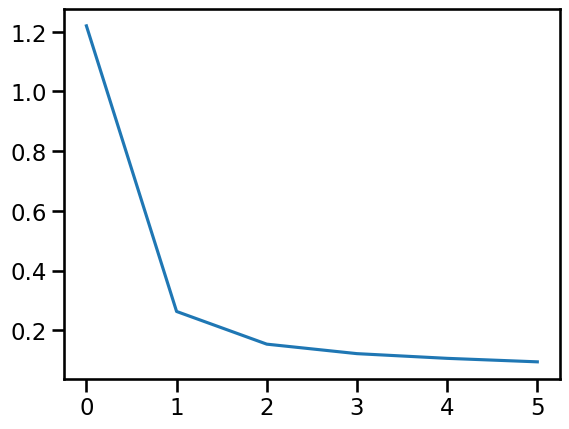

In [48]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# re-set MAX_LENGTH
MAX_LENGTH = 8

ENG_PREFIXES = (
    "i"
    "he",
    "she",
    "you",
    "we",
    "they"
)

input_lang, output_lang, pairs = prepareData('eng', 'fra', MAX_LENGTH, ENG_PREFIXES, True)
np.random.shuffle(pairs)

# Due to limited computing budget, we will only train the model for 30 epochs
N_EPOCHS = 30

###########################################################################
# TODO: Tune the hyper parameters. Define the model, optimizer, and       #
# learning rate scheduler (lr_scheduler). For your reference, the         #
# training loss should be around 0.9. And the testing loss should be      #
# smaller than 2.2.                                                       #
#                                                                         #
# Note that the **maximum** number of parameters for the entire model,    #
# encoder, and decoder are 3.5M, 0.8M, and 1.2M, respectively.            #
###########################################################################
BATCH_SIZE = 32
EMBED_DIM = 144
NUM_ATTN_HEADS = 4
FF_DIM = 288
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
LR = 0.001

model = Seq2SeqTransformer(
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    embed_dim=EMBED_DIM,
    num_heads=NUM_ATTN_HEADS,
    src_vocab_size=input_lang.n_words,
    tgt_vocab_size=output_lang.n_words,
    trx_ff_dim=FF_DIM,
    dropout=0.05
).to(device)

# **DO NOT** change this one
train_pairs, train_dataloader, test_pairs, test_dataloader = get_dataloader(pairs, BATCH_SIZE)

optimizer = optim.Adam(model.parameters(), lr=LR)
lr_scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1)
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

assert get_num_params(model) / 1e6 < 3.5
assert get_num_params(model.encoder) / 1e6 < 0.8
assert get_num_params(model.decoder) / 1e6 < 1.2
print('Number of parameters for the entire model:\t{:.3f}M'.format(get_num_params(model) / 1e6))
print('Number of parameters for the encoder:\t{:.3f}M'.format(get_num_params(model.encoder) / 1e6))
print('Number of parameters for the decoder:\t{:.3f}M'.format(get_num_params(model.decoder) / 1e6))

# As a reference, your training loss should be around 0.09.
train(train_dataloader, model, N_EPOCHS, optimizer, lr_scheduler, learning_rate=LR, use_causal_mask=True, print_every=1, plot_every=5)

In [51]:
from tqdm import tqdm

def compute_inference_loss(dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in tqdm(dataloader):
            input_tensor, target_tensor = data

            decoder_outputs = model(input_tensor)


            seq_len = min(decoder_outputs.size(1), target_tensor.size(1))
            decoder_outputs = decoder_outputs[:, :seq_len]
            target_tensor = target_tensor[:, :seq_len]

            loss = F.nll_loss(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.reshape(-1)
            )

            total_loss += loss.item()

    return total_loss / len(dataloader)

# Your testing loss should be smaller than 2.2
test_loss = compute_inference_loss(test_dataloader)
print('testing loss: {:.3f}'.format(test_loss))

# Let's check the model's output
print('\n=== Sample output on the testing set. ===')
evaluateRandomly(model, test_pairs)


100%|██████████| 46/46 [00:01<00:00, 34.84it/s]


testing loss: 2.988

=== Sample output on the testing set. ===
> elle nous a explique ses raisons
= she explained her reasons to us
< she was wearing long <EOS>

> nous avons attendu toute la matinee
= we ve been waiting all morning
< we ve got there <EOS>

> faut que tu sois plus organise !
= you gotta get more organized
< you gotta get more organized <EOS>

> elle veut epouser un homme riche
= she wants to marry a rich man
< she wants to marry a rich man <EOS>

> nous le ferons demain
= we ll do it tomorrow
< we ll do it tomorrow <EOS>

> tu as l air parfait
= you look perfect
< you look perfect <EOS>

> tu cours
= you run
< you have to use <EOS>

> tu es maigrichon
= you re skinny
< you re skinny <EOS>

> vous etes trop maigrichonnes
= you re too skinny
< you re too skinny <EOS>

> ils ne trouverent pas une telle preuve
= they found no such proof
< they found no such proof <EOS>



In [52]:
# Let's check the inference-time loss on the training set
train_loss = compute_inference_loss(train_dataloader)
print('training loss: {:.3f}'.format(train_loss))

100%|██████████| 411/411 [00:12<00:00, 31.91it/s]

training loss: 0.720


<font size='4' color='red'>Task 2.4 (inline question): The inference-time loss is higher than the training-time loss for the same training set. Briefly explain why. (7 points) </font>

[Your answer]: